## Imports

In [1]:
import load_data
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import os
import preprocess
from tensorflow import keras

## Constants 

In [2]:
# SAVE_HISTORY = True: Es speichert die Plots im Ordner "test_results"
SAVE_HISTORY = True

# MODEL_SAVE = True: Es speichert das Modell im Ordner "arch" mit den Name von "MODEL_NAME"
MODEL_SAVE = False
MODEL_NAME = "Default" # Am besten mit der Aenderung im Modell bennen 
MODEL_DIR_NAME = pathlib.Path(os.getcwd()).joinpath('arch')
TEST_RESULT_DIR_NAME = pathlib.Path(os.getcwd()).joinpath('test_results')

EPOCHS = 5

IMAGE_WIDTH = preprocess.image_width
IMAGE_HEIGHT = preprocess.image_height

## Load Data

In [3]:
load_data.print_samples()
x_train_img_paths, y_train_labels = load_data.get_train_data()
x_test_img_paths, y_test_labels = load_data.get_test_data()
x_val_img_paths, y_val_labels = load_data.get_validation_data()

Total train samples: 10209
Total validation samples: 567
Total test samples: 568
Maximum length:  93
Vocab size:  79


In [4]:
print(f"Training path: {x_train_img_paths[0:2]}", y_train_labels[0:2])
print(f"Validation path: {x_val_img_paths[0:2]}", y_val_labels[0:2])
print(f"Testing path: {x_test_img_paths[0:2]}", y_test_labels[0:2])

Training path: ['data\\lines\\m06\\m06-106\\m06-106-03.png', 'data\\lines\\a01\\a01-132u\\a01-132u-03.png'] ['and|Haris|there|were|many|events|.|Chief|of|these|was', 'adjust|the|financing|-|which|Mr.|Powell']
Validation path: ['data\\lines\\b04\\b04-034\\b04-034-04.png', 'data\\lines\\a05\\a05-004\\a05-004-05.png'] ['Newmarket|urban|council|,|says|:|"|I|shall|always|feel|this|as|a', 'and|operations|.|This|would|apply|also|in|the']
Testing path: ['data\\lines\\a02\\a02-093\\a02-093-01.png', 'data\\lines\\n02\\n02-049\\n02-049-03.png'] ['priority|to|the|clash|over|Northern|Rhodesia|on|his', 'look|as|though|it|was|only|what|you|expected|of|me|,']


## Create Dataset

In [5]:
# Has to be here because load data functions need to be called before
import tokenizer

# takes eternity
#x_train, y_train = tokenizer.prepare_data(x_train_img_paths, y_train_labels) 
#x_test, y_test = tokenizer.prepare_data(x_test_img_paths, y_test_labels)
train_ds = tokenizer.prepare_dataset(x_train_img_paths, y_train_labels)
val_ds = tokenizer.prepare_dataset(x_val_img_paths, y_val_labels)
test_ds = tokenizer.prepare_dataset(x_test_img_paths, y_test_labels)

## Show Examples

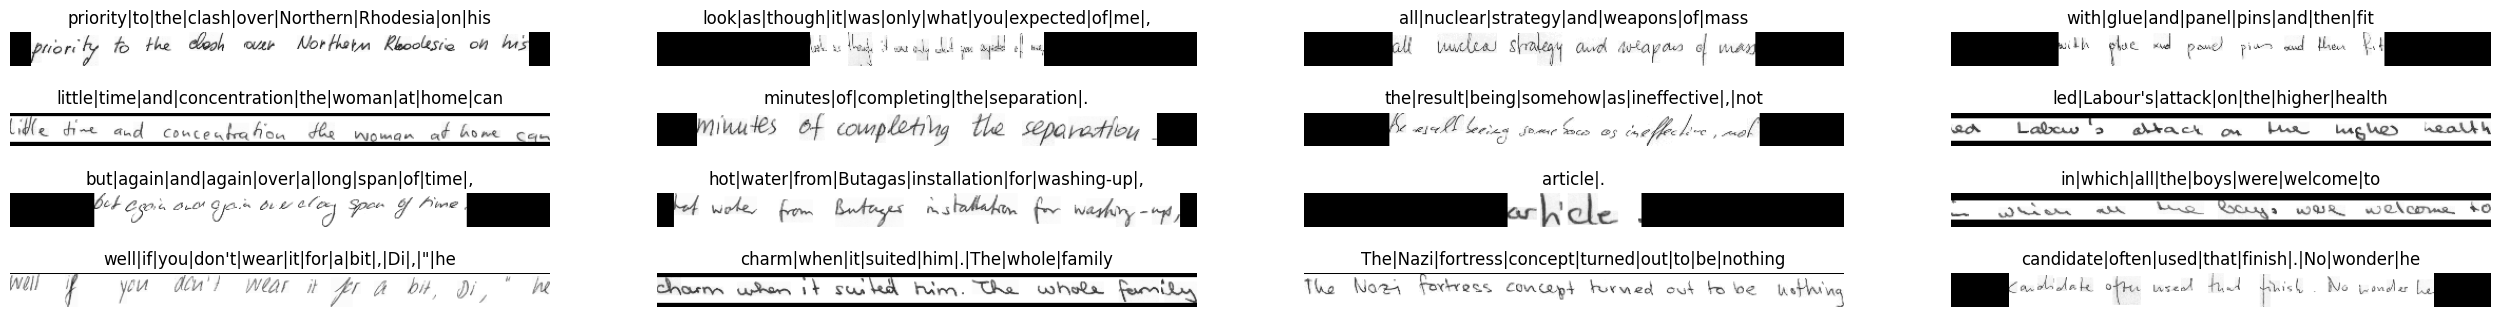

In [6]:
for data in test_ds.take(1):
    images, labels = data["image"], data["label"]

    ax = plt.subplots(4, 4, figsize=(32, 4))[1]

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, tokenizer.padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(tokenizer.num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()

## CTC Layer

In [7]:
import keras
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

## Keras Model

In [8]:
def build_model_default():
    # Inputs to the model
    input_img = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((IMAGE_WIDTH // 4), (IMAGE_HEIGHT // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(len(tokenizer.char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name=MODEL_NAME)
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model

In [10]:
def train_model(model):
    prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)

    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,)
    return prediction_model, history

In [11]:
# Get the model.
model = build_model_default()
model.summary()

Model: "Default"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 512, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 512, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 256, 16, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 256, 16, 64)  18496       ['pool1[0][0]']            

In [12]:
prediction_model, history = train_model(model)

Epoch 1/5
160/160 [==============================] - 32s 144ms/step - loss: 143.2619 - val_loss: 134.1227
Epoch 2/5
160/160 [==============================] - 17s 104ms/step - loss: 134.2943 - val_loss: 133.1877
Epoch 3/5
160/160 [==============================] - 17s 106ms/step - loss: 127.6196 - val_loss: 114.3182
Epoch 4/5
160/160 [==============================] - 18s 111ms/step - loss: 107.6732 - val_loss: 97.8760
Epoch 5/5
160/160 [==============================] - 17s 108ms/step - loss: 94.9185 - val_loss: 85.2311


## Helper functions


In [13]:
def plot_history_simple(history):
    """
    Plottet die Historie des Trainings eines Models

    :param history: Das trainierte Modell
    :return: void
    """
    metrics = history.history
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.show()

In [14]:
def plot_history(history, name, dir_path):
    """
    Plottet die Historie des Trainings eines Models und speichert die in einem Verzeichnis ab 

    :param history: Das trainierte Modell
    :param name: Name, wie das Modell gespeicht werden soll
    :param name: Verzeichniss, wo der Plot gespeichert weren soll
    :return: void
    """
    metrics = history.history
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.title('Name: '+name)
    path = os.path.join(dir_path, name + '_history.png')
    plt.savefig(path)
    plt.show()

In [15]:
def create_dir(path_to_dir):
    isExist = os.path.exists(path_to_dir)
    if not isExist:
        os.makedirs(path_to_dir)

In [16]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :load_data.max_len]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(tokenizer.num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [17]:
def plot_evaluation(name, dir_path, save):
    if save:
        path = os.path.join(dir_path, name + '_result.png')
        plt.savefig(path)

    for batch in val_ds.take(1):
        batch_images = batch["image"]
        _, ax = plt.subplots(4, 4, figsize=(32, 4))

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        for i in range(16):
            img = batch_images[i]
            img = tf.image.flip_left_right(img)
            img = tf.transpose(img, perm=[1, 0, 2])
            img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
            img = img[:, :, 0]

            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")   
            

    plt.show()


In [18]:
#test_loss, test_accuracy = model.evaluate(test_ds, verbose=2)

## Model Testing

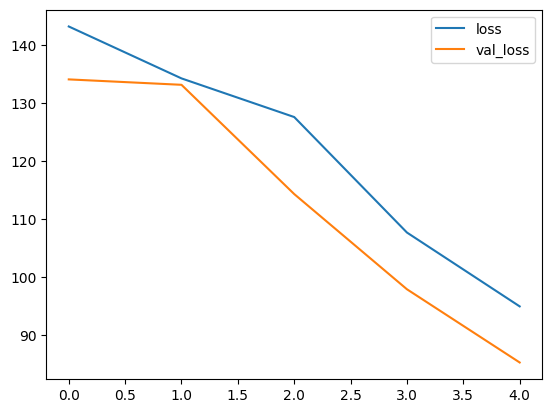

2/2 [==============================] - 0s 26ms/step


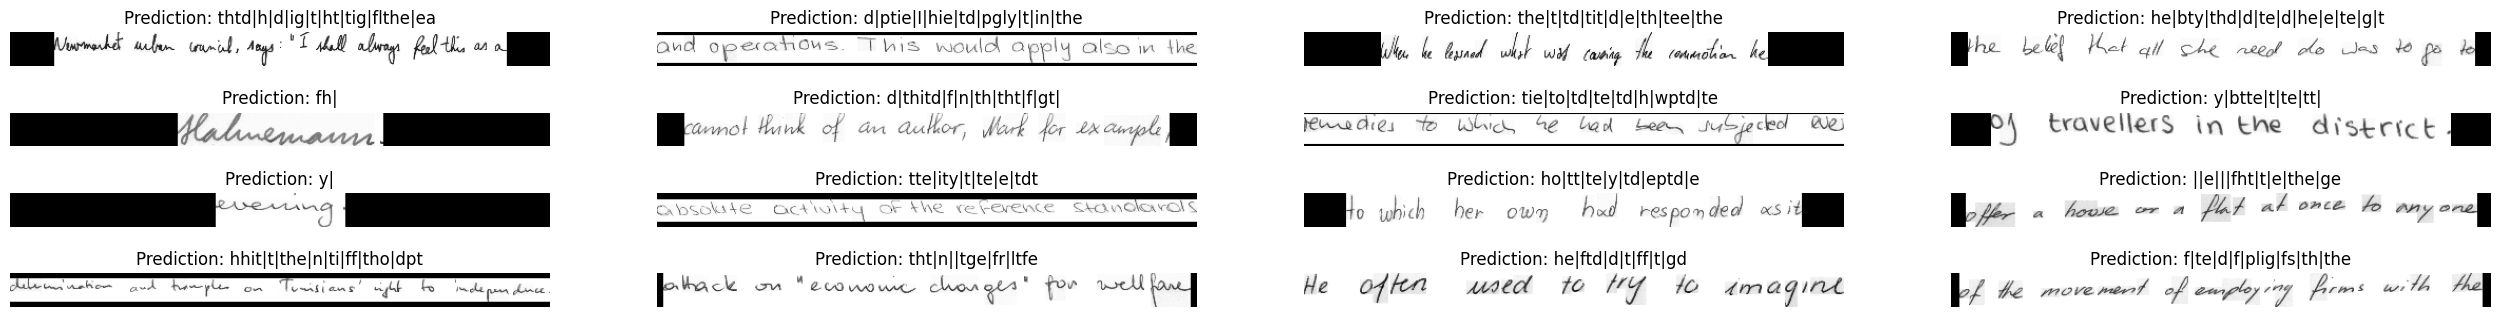

In [21]:
files_with_model_name = [file for file in os.listdir(TEST_RESULT_DIR_NAME) if MODEL_NAME in file]
metrics = history.history

NAME = "{name}_{epoch}E_{height}H_{width}W_{loss}L_{val_loss}VL".format(
    name=MODEL_NAME, epoch=EPOCHS, height=IMAGE_HEIGHT, width=IMAGE_WIDTH,
    loss=round(metrics['loss'][-1]), val_loss=round(metrics['val_loss'][-1]))

if not files_with_model_name:
    if SAVE_HISTORY:
        if not os.path.exists(TEST_RESULT_DIR_NAME):
            create_dir(TEST_RESULT_DIR_NAME)
        plot_history(history, NAME, TEST_RESULT_DIR_NAME)
        plot_evaluation(NAME, TEST_RESULT_DIR_NAME, True)
else:
    plot_history_simple(history)
    plot_evaluation(NAME, TEST_RESULT_DIR_NAME, False)


# Save the Model

In [20]:
if MODEL_SAVE:
    if not os.path.exists(MODEL_DIR_NAME):
        create_dir(MODEL_DIR_NAME)
    model.save(os.path.join(MODEL_DIR_NAME, "{model_name}".format(model_name=MODEL_NAME)))
    #model.save_weights(os.path.join(MODEL_DIR_NAME, "weights.keras"), overwrite=True, save_format=None, options=None)
    json_string = model.to_json()

    with open(os.path.join(MODEL_DIR_NAME, "model"),'w') as f:
        f.write(json_string)